In [1]:
import pandas as pd
import zipfile as zf
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import coint
from dune_client.client import DuneClient
from dune_client.query import QueryBase
from dotenv import load_dotenv
import os
load_dotenv()
GRAPH = os.getenv("GRAPH")

In [2]:
data = zf.ZipFile('ETHUSDT-aggTrades-2025-10.zip')
df = pd.read_csv(data.open('ETHUSDT-aggTrades-2025-10.csv'))

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50227412 entries, 0 to 50227411
Data columns (total 8 columns):
 #   Column            Dtype  
---  ------            -----  
 0   1720750793        int64  
 1   4145.15000000     float64
 2   0.00990000        float64
 3   2902981421        int64  
 4   2902981421.1      int64  
 5   1759276800336276  int64  
 6   False             bool   
 7   True              bool   
dtypes: bool(2), float64(2), int64(4)
memory usage: 2.3 GB


In [4]:
df.to_parquet('ETHUSDT-aggTrades-2025-10.parquet')

In [ ]:

API_KEY = os.getenv('DUNE')
dune = DuneClient(API_KEY)
result = dune.get_latest_result(6273751)

HTTPError: 402 Client Error: Payment Required for url: https://api.dune.com/api/v1/execution/01KB63VJDWB21MY826K0QCR3JF/results?allow_partial_results=true&limit=32000

In [21]:
import requests
import pandas as pd
from datetime import datetime, timezone

# Replace with your The Graph API key (or leave blank if not required)
API_KEY = "<YOUR_API_KEY>"  # optional
SUBGRAPH_ID = "H6NdbpW66uYH99LMDEjpBQokAen2Wa8kGyUhbNs1799P"
GRAPHQL_ENDPOINT = f"https://gateway.thegraph.com/api/subgraphs/id/HMuAwufqZ1YCRmzL2SfHTVkzZovC9VL2UAKhjvRqKiR1"

# 1) Define the date filter: Oct 1 2025 UTC
start = int(datetime(2025, 10, 1, 0, 0, tzinfo=timezone.utc).timestamp())
end   = int(datetime(2025, 10, 2, 0, 0, tzinfo=timezone.utc).timestamp())

# 2) Query: swap events in that day (filtering by timestamp only)
query = """
query($t_start: Int!, $t_end: Int!) {
  swaps(
    where: {
      timestamp_gte: $t_start,
      timestamp_lt: $t_end
    },
    first: 1000,
    orderBy: timestamp,
    orderDirection: asc
  ) {
    id
    timestamp
    amount0
    amount1
    amountUSD
    pool {
      id
      token0 { symbol id }
      token1 { symbol id }
    }
    sender
    recipient
    transaction {
      id
      blockNumber
    }
  }
}
"""

variables = {
    "t_start": start,
    "t_end": end
}

resp = requests.post(GRAPHQL_ENDPOINT, json={"query": query, "variables": variables})
resp.raise_for_status()
data = resp.json()

swaps = data.get("data", {}).get("swaps", [])
df = pd.DataFrame(swaps)
print(df.head())


Empty DataFrame
Columns: []
Index: []


In [ ]:
from web3 import Web3
import pandas as pd
import time
import datetime

# ---------- CONFIG ----------
RPC_URL = "https://YOUR_ARCHIVE_NODE_URL"
w3 = Web3(Web3.HTTPProvider(RPC_URL))

# Address of the pool(s) you care about (or None for all pools)
# e.g. WETH-USDT pool — substitute the correct address(s).
POOL_ADDRESSES = [
    "0xYourPoolAddressHere".lower(),  # optionally multiple pools
]

# Uniswap V3 Swap event signature / topic
SWAP_EVENT_TOPIC = w3.keccak(text="Swap(address,address,int256,int256,uint160,uint128,int24)").hex()

# Define block range for dates Oct 1–3 2025
dt_start = datetime.datetime(2025, 10, 1, 0, 0, tzinfo=datetime.timezone.utc)
dt_end   = datetime.datetime(2025, 10, 4, 0, 0, tzinfo=datetime.timezone.utc)
block_start = w3.eth.get_block("earliest")["number"]
block_end   = w3.eth.get_block("latest")["number"]

# Optionally convert date → block number (naive way: estimate, or binary search)
# For simplicity: scan full range and filter by timestamp later.

# ---------- FETCH LOGS ----------
filter_params = {
    "fromBlock": block_start,
    "toBlock": block_end,
    "topics": [SWAP_EVENT_TOPIC],
}
if POOL_ADDRESSES:
    filter_params["address"] = POOL_ADDRESSES

logs = w3.eth.get_logs(filter_params)

print("Got logs:", len(logs))

# ---------- PARSE & FILTER ----------
parsed = []
for log in logs:
    # log contains: blockNumber, transactionHash, topics, data
    blk = w3.eth.get_block(log["blockNumber"])
    ts = blk["timestamp"]
    if ts < int(dt_start.timestamp()) or ts >= int(dt_end.timestamp()):
        continue

    parsed.append({
        "blockNumber": log["blockNumber"],
        "txHash": log["transactionHash"].hex(),
        "logIndex": log["logIndex"],
        "topics": log["topics"],
        "data": log["data"],
        "timestamp": datetime.datetime.utcfromtimestamp(ts),
    })

df = pd.DataFrame(parsed)
print(df.head(), df.shape)

# Then you’d decode `data` according to the Swap event ABI to get amount0, amount1, etc.


In [1]:
import requests
import json

API_KEY = "08359c5477f79891ff91a3ac7c535ef6"   # <-- replace with your key
SUBGRAPH_ID = "HMuAwufqZ1YCRmzL2SfHTVkzZovC9VL2UAKhjvRqKiR1"

url = f"https://gateway.thegraph.com/api/{API_KEY}/subgraphs/id/{SUBGRAPH_ID}"

query = """
{
  swaps(first: 5, orderBy: timestamp, orderDirection: desc) {
    id
    amount0
    amount1
    sender
    recipient
    timestamp
  }
}
"""

response = requests.post(url, json={"query": query})

# Convert to JSON
data = response.json()

print(json.dumps(data, indent=2))


{
  "data": {
    "swaps": [
      {
        "amount0": "0.000000000000000123",
        "amount1": "-0.000000457590421438",
        "id": "0xd8ac0baab91af5cdda339be3e27f25efa4d0a31e580db0e559dd1401ee591677-391",
        "recipient": "0x62bfd6e1f72611e9e0fccf939ce03d1294e966f3",
        "sender": "0x2626664c2603336e57b271c5c0b26f421741e481",
        "timestamp": "1764459337"
      },
      {
        "amount0": "0.000000000000000123",
        "amount1": "-0.000000457590421438",
        "id": "0x8345c7bc3ea7253ab354fcc88ca42e8ab34fd775fef3ff625da040204608da7b-387",
        "recipient": "0xc190767d14900c5f54bfab64d8028db2678bcf11",
        "sender": "0x2626664c2603336e57b271c5c0b26f421741e481",
        "timestamp": "1764459337"
      },
      {
        "amount0": "-0.006181681540598785",
        "amount1": "14193.490593",
        "id": "0x79fdf10d9d516b9c88b18c61bcd58d0cd7e1ee35d7f8ca949895d10a353bdb26-407",
        "recipient": "0xbf44de8fc9eeeed8615b0b3bc095cb0ddef35e09",
        "sender

In [4]:
import requests
import json

API_KEY = "08359c5477f79891ff91a3ac7c535ef6"
SUBGRAPH_ID = "HMuAwufqZ1YCRmzL2SfHTVkzZovC9VL2UAKhjvRqKiR1"

url = f"https://gateway.thegraph.com/api/{API_KEY}/subgraphs/id/{SUBGRAPH_ID}"

query = """
{
  swaps(first: 100, orderBy: timestamp, orderDirection: desc) {
    id
    amount0
    amount1
    timestamp
    pool {
      id
      token0 { id symbol name decimals }
      token1 { id symbol name decimals }
    }
  }
}
"""

response = requests.post(url, json={"query": query})
print(json.dumps(response.json(), indent=2))


{
  "data": {
    "swaps": [
      {
        "amount0": "-0.015914161033764128",
        "amount1": "47.639609",
        "id": "0xf6575550b9187749f907d7e7656ee0193cf5cccbe553ba2435fb49af0146f6d6-71",
        "pool": {
          "id": "0xb4cb800910b228ed3d0834cf79d697127bbb00e5",
          "token0": {
            "decimals": "18",
            "id": "0x4200000000000000000000000000000000000006",
            "name": "Wrapped Ether",
            "symbol": "WETH"
          },
          "token1": {
            "decimals": "6",
            "id": "0x833589fcd6edb6e08f4c7c32d4f71b54bda02913",
            "name": "USD Coin",
            "symbol": "USDC"
          }
        },
        "timestamp": "1764459843"
      },
      {
        "amount0": "83.500116265670931197",
        "amount1": "-47.639609",
        "id": "0xf6575550b9187749f907d7e7656ee0193cf5cccbe553ba2435fb49af0146f6d6-68",
        "pool": {
          "id": "0x29183f918920a2aef0115a9c7374945589968aea",
          "token0": {
         

In [4]:
import requests

API_KEY = GRAPH
SUBGRAPH_ID = "HMuAwufqZ1YCRmzL2SfHTVkzZovC9VL2UAKhjvRqKiR1"

url = f"https://gateway.thegraph.com/api/{API_KEY}/subgraphs/id/{SUBGRAPH_ID}"

query_pools = """
{
  pools(first: 1000) {
    id
    token0 { id symbol }
    token1 { id symbol }
  }
}
"""

resp = requests.post(url, json={"query": query_pools}).json()
pools = resp["data"]["pools"]

eth_usdt_pools = [
    p["id"] for p in pools
    if {"ETH", "WETH"} & {p["token0"]["symbol"], p["token1"]["symbol"]}
    and "USDT" in {p["token0"]["symbol"], p["token1"]["symbol"]}
]

print("ETH/USDT Pools:", eth_usdt_pools)


ETH/USDT Pools: []


In [10]:
SUBGRAPH_ID = "HMuAwufqZ1YCRmzL2SfHTVkzZovC9VL2UAKhjvRqKiR1"

url = f"https://gateway.thegraph.com/api/{API_KEY}/subgraphs/id/{SUBGRAPH_ID}"

# Symbols to treat as "ETH" and "USDT" families on Arbitrum
ETH_SYMBOLS = {"ETH", "WETH", "WETH.e", "ETH.e"}
USDT_SYMBOLS = {"USDT", "USDT.e", "USDTe", "axlUSDT"}

batch_size = 1000
skip = 0
found_pool = None

while True:
    query = f"""
    {{
      pools(first: {batch_size}, skip: {skip}) {{
        id
        feeTier
        token0 {{ id symbol name }}
        token1 {{ id symbol name }}
      }}
    }}
    """

    resp = requests.post(url, json={"query": query})
    data = resp.json()

    if "errors" in data:
        print("GraphQL errors:", data["errors"])
        break

    pools = data["data"]["pools"]
    if not pools:
        print("No more pools. Reached end of dataset.")
        break

    for p in pools:
        t0 = p["token0"]["symbol"]
        t1 = p["token1"]["symbol"]

        if (t0 in ETH_SYMBOLS and t1 in USDT_SYMBOLS) or (t1 in ETH_SYMBOLS and t0 in USDT_SYMBOLS):
            found_pool = p
            break

    if found_pool is not None:
        break

    skip += batch_size
    time.sleep(0.2)  # be gentle with the gateway

if found_pool:
    print("✅ Found ETH/USDT-like pool:")
    print("Pool ID:   ", found_pool["id"])
    print("Fee tier:  ", found_pool.get("feeTier"))
    print("Token0:", found_pool["token0"]["symbol"], "-", found_pool["token0"]["id"])
    print("Token1:", found_pool["token1"]["symbol"], "-", found_pool["token1"]["id"])
else:
    print("❌ No ETH/USDT-like pool found with current symbol sets.")

✅ Found ETH/USDT-like pool:
Pool ID:    0x007baf34f89b8bb9f1038dbcc00a28bbe19f8317
Fee tier:   3000
Token0: WETH - 0x4200000000000000000000000000000000000006
Token1: USDT - 0x601c6a71747394c97978f18ef77e775b0f29d264


In [ ]:
SUBGRAPH_ID = "HMuAwufqZ1YCRmzL2SfHTVkzZovC9VL2UAKhjvRqKiR1"
url = f"https://gateway.thegraph.com/api/{API_KEY}/subgraphs/id/{SUBGRAPH_ID}"

POOL_ID = found_pool  # <- from the previous script

START_TS = 1759276800   # 2025-10-01 00:00:00 UTC
END_TS   = 1759449600   # 2025-10-03 00:00:00 UTC

all_swaps = []
skip = 0
batch_size = 1000

while True:
    query = f"""
    {{
      swaps(
        first: {batch_size},
        skip: {skip},
        where: {{
          pool: "{POOL_ID}",
          timestamp_gte: {START_TS},
          timestamp_lt: {END_TS}
        }},
        orderBy: timestamp,
        orderDirection: asc
      ) {{
        id
        timestamp
        amount0
        amount1
        amountUSD
        sender
        recipient
        pool {{
          token0 {{ symbol }}
          token1 {{ symbol }}
        }}
      }}
    }}
    """

    resp = requests.post(url, json={"query": query})
    data = resp.json()

    if "errors" in data:
        print("GraphQL errors:", data["errors"])
        break

    swaps = data["data"]["swaps"]
    if not swaps:
        break

    all_swaps.extend(swaps)
    skip += batch_size

print(f"Total swaps for pool {POOL_ID} in window: {len(all_swaps)}")
df = pd.DataFrame(all_swaps)
print(df.head())

GraphQL errors: [{'message': "bad indexers: {0x1b7e0068ca1d7929c8c56408d766e1510e54d98d: Unavailable(too far behind), 0x7bb834017672b1135466661d8dd69c5dd0b3bf51: BadResponse(unattestable response: Store error: store error: Invalid character '{' at position 0), 0xe13840a2e92e0cb17a246609b432d0fa2e418774: BadResponse(unattestable response: Store error: store error: Invalid character '{' at position 0), 0xedca8740873152ff30a2696add66d1ab41882beb: BadResponse(unattestable response: Store error: store error: Invalid character '{' at position 0), 0xf92f430dd8567b0d466358c79594ab58d919a6d4: BadResponse(unattestable response: Store error: store error: Invalid character '{' at position 0), 0xfeff9093f6b32d0e5cddba743b06a1fedb87c004: Unavailable(too far behind)}"}]
Total swaps for pool {'feeTier': '3000', 'id': '0x007baf34f89b8bb9f1038dbcc00a28bbe19f8317', 'token0': {'id': '0x4200000000000000000000000000000000000006', 'name': 'Wrapped Ether', 'symbol': 'WETH'}, 'token1': {'id': '0x601c6a71747394

In [15]:
SUBGRAPH_ID = "HMuAwufqZ1YCRmzL2SfHTVkzZovC9VL2UAKhjvRqKiR1"
url = f"https://gateway.thegraph.com/api/{API_KEY}/subgraphs/id/{SUBGRAPH_ID}"

POOL_ID = found_pool  # <- from the previous script

START_TS = 1759276800   # 2025-10-01 00:00:00 UTC
END_TS   = 1759449600   # 2025-10-03 00:00:00 UTC

all_swaps = []
skip = 0
batch_size = 1000

while True:
    query = f"""
    {{
      swaps(
        first: {batch_size},
        skip: {skip},
        where: {{
          timestamp_gte: {START_TS},
          timestamp_lt: {END_TS}
        }},
        orderBy: timestamp,
        orderDirection: asc
      ) {{
        id
        timestamp
        amount0
        amount1
        amountUSD
        sender
        recipient
        pool {{
          token0 {{ symbol }}
          token1 {{ symbol }}
        }}
      }}
    }}
    """

    resp = requests.post(url, json={"query": query})
    data = resp.json()

    if "errors" in data:
        print("GraphQL errors:", data["errors"])
        break

    swaps = data["data"]["swaps"]
    if not swaps:
        break

    all_swaps.extend(swaps)
    skip += batch_size

print(f"Total swaps for pool {POOL_ID} in window: {len(all_swaps)}")
df = pd.DataFrame(all_swaps)
print(df.head())

KeyboardInterrupt: 

## Pull all swaps for a given pool from The Graph

In [ ]:
import requests
import pandas as pd
from datetime import datetime, timedelta
import time


SUBGRAPH_ID = "HMuAwufqZ1YCRmzL2SfHTVkzZovC9VL2UAKhjvRqKiR1"
url = f"https://gateway.thegraph.com/api/{API_KEY}/subgraphs/id/{SUBGRAPH_ID}"

POOL_ID = "0x007baf34f89b8bb9f1038dbcc00a28bbe19f8317"

START_TS = 1759276800   # 2025-10-01 00:00 UTC
END_TS   = 1759449600   # 2025-10-03 00:00 UTC

def query_window(start_ts, end_ts):
    """Query swaps for a small timestamp window."""
    swaps = []
    skip = 0
    batch = 1000

    while True:
        query = f"""
        {{
          swaps(
            first: {batch},
            skip: {skip},
            where: {{
              pool: "{POOL_ID}",
              timestamp_gte: {start_ts},
              timestamp_lt: {end_ts}
            }},
            orderBy: timestamp,
            orderDirection: asc
          ) {{
            id
            timestamp
            amount0
            amount1
            amountUSD
            sender
            recipient
            pool {{
              token0 {{ symbol }}
              token1 {{ symbol }}
            }}
          }}
        }}
        """

        resp = requests.post(url, json={"query": query}).json()

        if "errors" in resp:
            print("ERROR:", resp["errors"])
            break

        batch_data = resp["data"]["swaps"]
        if not batch_data:
            break

        swaps.extend(batch_data)
        skip += batch

    return swaps

# break the 2-day range into hourly windows (FAST)
all_swaps = []
ts = START_TS
step = 3600  # one hour

while ts < END_TS:
    window_swaps = query_window(ts, ts + step)
    all_swaps.extend(window_swaps)
    ts += step

df = pd.DataFrame(all_swaps)
print("Total swaps:", len(df))
print(df.head())


















































Total swaps: 0
Empty DataFrame
Columns: []
Index: []


## Search for pools with eth/usdt pair or similar

In [23]:
import requests
import time
SUBGRAPH_ID = "HMuAwufqZ1YCRmzL2SfHTVkzZovC9VL2UAKhjvRqKiR1"
url = f"https://gateway.thegraph.com/api/{GRAPH}/subgraphs/id/{SUBGRAPH_ID}"

pools = []
skip = 0
batch = 1000

while True:
    query = f"""
    {{
      pools(first: {batch}, skip: {skip}) {{
        id
        feeTier
        token0 {{ symbol id }}
        token1 {{ symbol id }}
      }}
    }}
    """
    r = requests.post(url, json={"query": query}).json()

    if "errors" in r:
        print("ERROR:", r["errors"])
        break

    batch_pools = r["data"]["pools"]
    if not batch_pools:
        break

    pools.extend(batch_pools)
    skip += batch
    time.sleep(0.1)

print("Total pools:", len(pools))


ERROR: [{'message': 'bad indexers: {0x1b7e0068ca1d7929c8c56408d766e1510e54d98d: Unavailable(too far behind), 0x7bb834017672b1135466661d8dd69c5dd0b3bf51: Timeout, 0xe13840a2e92e0cb17a246609b432d0fa2e418774: Timeout, 0xedca8740873152ff30a2696add66d1ab41882beb: BadResponse(unattestable response: Query timed out), 0xf92f430dd8567b0d466358c79594ab58d919a6d4: BadResponse(expected value at line 1 column 1), 0xfeff9093f6b32d0e5cddba743b06a1fedb87c004: Unavailable(too far behind)}'}]
Total pools: 4000


In [25]:
pools

[{'feeTier': '10000',
  'id': '0x0000051c3bd707d5aa50a28eeaf54fb2cbf91196',
  'token0': {'id': '0x24ba86c5d0febedc37a4aad9e67f299b4a7d9f88',
   'symbol': 'CLK1'},
  'token1': {'id': '0x4200000000000000000000000000000000000006',
   'symbol': 'WETH'}},
 {'feeTier': '10000',
  'id': '0x00000f5983451c31d85304b38563ce8893b557a8',
  'token0': {'id': '0x4200000000000000000000000000000000000006',
   'symbol': 'WETH'},
  'token1': {'id': '0x6ccb79fdf6f5cd197c59ea5a7044cf342150ddec',
   'symbol': 'PORTUGUS'}},
 {'feeTier': '10000',
  'id': '0x0000102fc6ce6dee1c693da23b2ee4f76df9462f',
  'token0': {'id': '0x4200000000000000000000000000000000000006',
   'symbol': 'WETH'},
  'token1': {'id': '0x895623ec529c25b6ab49457c52853d0b3c188d94',
   'symbol': 'Celebrate 🎊 for more on Zora 🎉'}},
 {'feeTier': '10000',
  'id': '0x000012903920c8f4e4c8adca4679784b18ecc84f',
  'token0': {'id': '0x4200000000000000000000000000000000000006',
   'symbol': 'WETH'},
  'token1': {'id': '0x4342c5067f43dc750f6a21293c63b5a4

In [24]:
ETH_LIKE = {"ETH", "WETH", "WETH.e", "ETH.e"}
USDT_LIKE = {"USDT", "USDT.e", "USDTe", "axlUSDT", "bridgedUSDT", "USDTb"}

eth_usdt_candidates = []

for p in pools:
    s0 = p["token0"]["symbol"]
    s1 = p["token1"]["symbol"]
    if (s0 in ETH_LIKE and s1 in USDT_LIKE) or (s0 in USDT_LIKE and s1 in ETH_LIKE):
        eth_usdt_candidates.append(p)

print("Found ETH/USDT-like pools:")
for c in eth_usdt_candidates:
    print(c)


Found ETH/USDT-like pools:
{'feeTier': '3000', 'id': '0x007baf34f89b8bb9f1038dbcc00a28bbe19f8317', 'token0': {'id': '0x4200000000000000000000000000000000000006', 'symbol': 'WETH'}, 'token1': {'id': '0x601c6a71747394c97978f18ef77e775b0f29d264', 'symbol': 'USDT'}}


## Symbol names

In [22]:
query = """
{
  swaps(first: 1000, orderBy: timestamp, orderDirection: desc) {
    pool {
      id
      token0 {symbol}
      token1 {symbol}
    }
  }
}
"""

resp = requests.post(url, json={"query": query}).json()

symbols = set()
for s in resp["data"]["swaps"]:
    symbols.add(s["pool"]["token0"]["symbol"])
    symbols.add(s["pool"]["token1"]["symbol"])

print(sorted(symbols))


['$ARTU', '$RDAC', '$stong', '420', 'A0X', 'ADS', 'AERO', 'AFFINE', 'AGE', 'AGENTIC', 'AIXBT', 'ALI', 'ALTT', 'APOLLO-11', 'AUSTIN', 'AVNT', 'AWESOME', 'AWESOME-FLUTTER', 'BANG', 'BARKBARK', 'BASED', 'BCHB', 'BIO', 'BLACKHOLE', 'BNKR', 'BOARDGAME.IO', 'BOB', 'BOOTSTRAPADMIN', 'BORED', 'BOXMOT', 'BRACKY', 'BRUMP', 'BTCB', 'CAMOUFOX', 'CANVAS', 'CARGO-DIST', 'CAW', 'CECIL', 'CGLM', 'CGN', 'CHARLIE', 'CHOKIDAR', 'CLANKER', 'COLIMA', 'COMMANDER.JS', 'COMPROMISE', 'CORE', 'CORNI ', 'CPP2IL', 'CREATE', 'CUPY', 'DAI', 'DAYBYDAYCRM', 'DEAD', 'DEEP-LIVE-CAM', 'DELTA', 'DEUS', 'DEV', 'DOCSGPT', 'DOKPLOY', 'DOLA', 'DYNAMICDATA', 'ENA', 'ENG', 'ESHARE', 'ESX', 'EURC', 'ElonRWA', 'FASTIFY', 'FLOWER', 'FLOWISE', 'FOOMLOTTERY', 'FP-TS', 'FREYA', 'FULLCALENDAR', 'FULLPAGE.JS', 'FUSE', 'GAME', 'GDAL', 'GDK', 'GIT-CLIFF', 'GLANCES', 'GLICOL', 'GLSLVIEWER', 'GMRT', 'GNS', 'GO-RESTFUL', 'GO-ZERO', 'GOACCESS', 'GOCHU', 'GOOEY', 'GYMNASIUM', 'HARMONY', 'HASH', 'HEIMDALL', 'HI.EVENTS', 'HIGHER', 'HOPPSCOTCH'

## Optimized query

In [3]:
import requests
import pandas as pd
import time
import concurrent.futures

# -------------------------
# CONFIGURATION
# -------------------------
API_KEY = GRAPH
SUBGRAPH_ID = "HMuAwufqZ1YCRmzL2SfHTVkzZovC9VL2UAKhjvRqKiR1"
URL = f"https://gateway.thegraph.com/api/{API_KEY}/subgraphs/id/{SUBGRAPH_ID}"

# Oct 1–3, 2025 (Unix timestamps)
START_TS = 1759276800
END_TS   = 1759449600

# Parallelization settings
WINDOW_SIZE = 3600         # 1 hour windows
MAX_WORKERS = 8            # tune based on your machine
RETRIES = 5                # retry on indexer timeouts

# ETH / USDT SYMBOL VARIANTS
ETH_LIKE = {"ETH", "WETH", "WETH.e", "ETH.e"}
USDT_LIKE = {"USDT", "USDT.e", "USDTe", "axlUSDT", "bridgedUSDT", "USDTb"}


# -------------------------
# QUERY FUNCTION (1-HR WINDOW)
# -------------------------
def fetch_window(start_ts, end_ts, retry=0):
    """Fetch swaps in a small timestamp window with retries."""
    query = f"""
    {{
      swaps(
        first: 1000,
        where: {{
          timestamp_gte: {start_ts},
          timestamp_lt: {end_ts}
        }},
        orderBy: timestamp,
        orderDirection: asc
      ) {{
        id
        timestamp
        amount0
        amount1
        amountUSD
        sender
        recipient
        pool {{
          id
          token0 {{ symbol id }}
          token1 {{ symbol id }}
        }}
      }}
    }}
    """

    try:
        resp = requests.post(URL, json={"query": query}, timeout=20).json()

        if "errors" in resp:
            # Retry on indexer issues
            if retry < RETRIES:
                time.sleep(0.3)
                return fetch_window(start_ts, end_ts, retry + 1)
            else:
                print("FAILED WINDOW:", start_ts, resp["errors"])
                return []

        return resp["data"]["swaps"]

    except requests.exceptions.Timeout:
        if retry < RETRIES:
            return fetch_window(start_ts, end_ts, retry + 1)
        else:
            print("TIMEOUT WINDOW:", start_ts)
            return []


# -------------------------
# PARALLEL EXECUTION
# -------------------------
def fetch_all_swaps():
    """Fetch all swaps across hourly windows in parallel."""
    tasks = []
    ts = START_TS

    while ts < END_TS:
        tasks.append((ts, ts + WINDOW_SIZE))
        ts += WINDOW_SIZE

    results = []
    print(f"Fetching {len(tasks)} hourly windows using {MAX_WORKERS} workers...")

    with concurrent.futures.ThreadPoolExecutor(max_workers=MAX_WORKERS) as executor:
        futures = [
            executor.submit(fetch_window, start, end)
            for start, end in tasks
        ]
        for f in concurrent.futures.as_completed(futures):
            results.extend(f.result())

    print("Total swaps fetched:", len(results))
    return results


# -------------------------
# EXTRACT ETH/USDT POOLS
# -------------------------
def extract_eth_usdt_pools(swaps):
    pools = set()

    for s in swaps:
        t0 = s["pool"]["token0"]["symbol"]
        t1 = s["pool"]["token1"]["symbol"]
        pid = s["pool"]["id"]

        if (t0 in ETH_LIKE and t1 in USDT_LIKE) or (t1 in ETH_LIKE and t0 in USDT_LIKE):
            pools.add(pid)

    print("ETH/USDT-like pools found:", pools)
    return pools


# -------------------------
# FILTER SWAPS LOCALLY
# -------------------------
def filter_swaps_by_pools(swaps, pools):
    return [s for s in swaps if s["pool"]["id"] in pools]

def normalize_swap(s):
    t0 = s["pool"]["token0"]["symbol"]
    t1 = s["pool"]["token1"]["symbol"]

    a0 = float(s["amount0"])
    a1 = float(s["amount1"])

    # Identify which token is ETH / USDT
    if t0 in ETH_LIKE:
        eth_amount = a0
        usdt_amount = a1
    elif t1 in ETH_LIKE:
        eth_amount = a1
        usdt_amount = a0
    else:
        eth_amount = None
        usdt_amount = None

    # Direction:
    # negative amount means the trader SENT (sold) that token.
    direction = (
        "ETH→USDT" if eth_amount < 0 else
        "USDT→ETH" if usdt_amount < 0 else 
        "unknown"
    )

    return {
        "id": s["id"],
        "timestamp": int(s["timestamp"]),
        "eth_amount": eth_amount,
        "usdt_amount": usdt_amount,
        "direction": direction,
        "pool": s["pool"]["id"]
    }



# -------------------------
# MAIN
# -------------------------
if __name__ == "__main__":
    # 1. Fetch all swaps for Oct 1–3 2025 (fast, parallel)
    all_swaps = fetch_all_swaps()

    # 2. Determine which pools are ETH/USDT-like
    pools = extract_eth_usdt_pools(all_swaps)

    if not pools:
        print("No ETH/USDT pools found in this dataset.")
        exit()

    # 3. Filter locally (avoid querying pools table)
    eth_usdt_swaps = filter_swaps_by_pools(all_swaps, pools)

    # 4. Convert to DataFrame
    df = pd.DataFrame(eth_usdt_swaps)
    normalized = [normalize_swap(s) for s in eth_usdt_swaps]
    df = pd.DataFrame(normalized)
    print(df.head())

    # Save the final result
    df.to_csv("eth_usdt_swaps_2025_oct1_3.csv", index=False)
    print("Saved to eth_usdt_swaps_2025_oct1_3.csv")


Fetching 48 hourly windows using 8 workers...
Total swaps fetched: 48000
ETH/USDT-like pools found: {'0xd92e0767473d1e3ff11ac036f2b1db90ad0ae55f', '0xd0d182fed9d119e1e41f5199266974f2546eb3f5', '0xce1d8c90a5f0ef28fe0f457e5ad615215899319a'}
                                                  id   timestamp  eth_amount  \
0  0xf54ecf1c0ba2e6cbedfe17aaf48cde3cb00402c24da1...  1759276801   -0.007114   
1  0x6c7279c62cc418d45210283cb04c8c5d18a93a05e461...  1759276803    0.000330   
2  0x812360882ce057152a07f9d3ff0a2d9834fce72ac511...  1759276803    0.000325   
3  0xa1862c96b7c902e84f95df0be62e09bf89c677aad564...  1759276803    0.000319   
4  0xf2f9738e82b9e7ca0cd57820c81f650c5f8b95630c77...  1759276803    0.000305   

   usdt_amount direction                                        pool  
0    29.507649  ETH→USDT  0xd92e0767473d1e3ff11ac036f2b1db90ad0ae55f  
1    -1.367409  USDT→ETH  0xd92e0767473d1e3ff11ac036f2b1db90ad0ae55f  
2    -1.346510  USDT→ETH  0xd92e0767473d1e3ff11ac036f2b1db90ad0ae55

In [5]:
df['eth_price'] = np.abs(df['usdt_amount']/ df['eth_amount'])

In [6]:
df

,id,timestamp,eth_amount,usdt_amount,direction,pool,eth_price
0,0xf54ecf1c0ba2e6cbedfe17aaf48cde3cb00402c24da1...,1759276801,-0.007114,29.507649,ETH→USDT,0xd92e0767473d1e3ff11ac036f2b1db90ad0ae55f,4147.802786
1,0x6c7279c62cc418d45210283cb04c8c5d18a93a05e461...,1759276803,0.000330,-1.367409,USDT→ETH,0xd92e0767473d1e3ff11ac036f2b1db90ad0ae55f,4143.835513
2,0x812360882ce057152a07f9d3ff0a2d9834fce72ac511...,1759276803,0.000325,-1.346510,USDT→ETH,0xd92e0767473d1e3ff11ac036f2b1db90ad0ae55f,4143.856378
3,0xa1862c96b7c902e84f95df0be62e09bf89c677aad564...,1759276803,0.000319,-1.320034,USDT→ETH,0xd92e0767473d1e3ff11ac036f2b1db90ad0ae55f,4143.798737
4,0xf2f9738e82b9e7ca0cd57820c81f650c5f8b95630c77...,1759276803,0.000305,-1.264180,USDT→ETH,0xd92e0767473d1e3ff11ac036f2b1db90ad0ae55f,4143.818511
...,...,...,...,...,...,...,...
3084,0x3eed809753515783ede1f9b26ab7f4793ba368a7f45f...,1759442461,-0.021686,97.083106,ETH→USDT,0xd92e0767473d1e3ff11ac036f2b1db90ad0ae55f,4476.670494
3085,0x204e51f0d4e1a4dd6f7c475de767a0d7ebb971a198fd...,1759442477,-0.012627,56.535678,ETH→USDT,0xd92e0767473d1e3ff11ac036f2b1db90ad0ae55f,4477.319050
3086,0x9fd3ebefe74303be7f64f72d90173c3477d9ff9a67d0...,1759442479,-0.027441,122.881507,ETH→USDT,0xd92e0767473d1e3ff11ac036f2b1db90ad0ae55f,4478.076568
3087,0xfde657500476d1dd63a5d80882aac92d660f8e1e5a14...,1759442481,-0.010668,47.781082,ETH→USDT,0xd92e0767473d1e3ff11ac036f2b1db90ad0ae55f,4478.797244


In [22]:
import asyncio
import aiohttp
import pandas as pd
import time
import math

# -------------------------
# CONFIG
# -------------------------
API_KEY = GRAPH
SUBGRAPH_ID = "HMuAwufqZ1YCRmzL2SfHTVkzZovC9VL2UAKhjvRqKiR1"
URL = f"https://gateway.thegraph.com/api/{API_KEY}/subgraphs/id/{SUBGRAPH_ID}"

START_TS = 1759276800
END_TS   = 1759449600

WINDOW_SIZE = 3600  # 1 hour
PAGE_SIZE = 1000
MAX_RETRIES = 5
CONCURRENT_REQUESTS = 40  # tune based on machine/network

ETH_LIKE = {"ETH"}
USDT_LIKE = {"USDT"}

# Canonical token addresses (Arbitrum One)
ETH_ADDRS = {
    "0x82af49447d8a07e3bd95bd0d56f35241523fbab1",  # WETH
    "0x4200000000000000000000000000000000000006",  # Native ETH wrapper (Arbitrum)
}


USDT_ADDRS = {
    '0xfde4c96c8593536e31f229ea8f37b2ada2699bb2'
}


# -------------------------
# GraphQL Query Builder
# -------------------------
def build_query(start_ts, end_ts, skip):
    return {
        "query": f"""
        {{
          swaps(
            first: {PAGE_SIZE},
            skip: {skip},
            where: {{
              timestamp_gte: {start_ts},
              timestamp_lt: {end_ts}
            }},
            orderBy: timestamp,
            orderDirection: asc
          ) {{
            id
            timestamp
            amount0
            amount1
            amountUSD
            pool {{
              id
              token0 {{ symbol id }}
              token1 {{ symbol id }}
            }}
          }}
        }}
        """
    }


# -------------------------
# Async Fetch (Single Request)
# -------------------------
async def fetch_page(session, start_ts, end_ts, skip, retry=0):
    try:
        async with session.post(URL, json=build_query(start_ts, end_ts, skip), timeout=30) as resp:
            data = await resp.json()

            # Handle GraphQL errors
            if "errors" in data:
                if retry < MAX_RETRIES:
                    await asyncio.sleep(0.2)
                    return await fetch_page(session, start_ts, end_ts, skip, retry + 1)
                return []

            return data["data"]["swaps"]

    except Exception:
        if retry < MAX_RETRIES:
            await asyncio.sleep(0.3)
            return await fetch_page(session, start_ts, end_ts, skip, retry + 1)
        return []


# -------------------------
# Fetch ALL Pages for a Window (Paginated)
# -------------------------
async def fetch_window(session, start_ts, end_ts):
    # First page to detect total size
    first_page = await fetch_page(session, start_ts, end_ts, 0)
    if not first_page:
        return []

    pages = [first_page]

    # If first page == PAGE_SIZE, we need pagination
    if len(first_page) == PAGE_SIZE:
        # Worst case, assume 10k swaps per hour → need ~10 pages
        # → aggressively parallelize pagination
        tasks = []
        for k in range(1, 20):  
            skip = k * PAGE_SIZE
            tasks.append(fetch_page(session, start_ts, end_ts, skip))

        all_pages = await asyncio.gather(*tasks)

        for pg in all_pages:
            if pg:
                pages.append(pg)
            if len(pg) < PAGE_SIZE:
                break

    # Flatten
    merged = [row for page in pages for row in page]
    return merged


# -------------------------
# Fetch All Windows in Parallel
# -------------------------
async def fetch_all_swaps():
    tasks = []
    ts = START_TS

    async with aiohttp.ClientSession() as session:
        while ts < END_TS:
            tasks.append(fetch_window(session, ts, ts + WINDOW_SIZE))
            ts += WINDOW_SIZE

        print(f"Launching {len(tasks)} hourly windows in parallel...")

        # Limit concurrency
        sem = asyncio.Semaphore(CONCURRENT_REQUESTS)

        async def sem_task(t):
            async with sem:
                return await t

        results = await asyncio.gather(*[sem_task(t) for t in tasks])

    # Flatten
    all_swaps = [s for window in results for s in window]
    print("Total swaps fetched:", len(all_swaps))
    return all_swaps


# -------------------------
# EXTRACT ETH/USDT POOLS (CORRECTED)
# -------------------------
def extract_eth_usdt_pools(swaps):
    pools = set()

    for s in swaps:
        t0 = s["pool"]["token0"]["id"].lower()
        t1 = s["pool"]["token1"]["id"].lower()
        pid = s["pool"]["id"]

        if (t0 in ETH_ADDRS and t1 in USDT_ADDRS) or \
           (t1 in ETH_ADDRS and t0 in USDT_ADDRS):
            pools.add(pid)

    print("ETH/USDT pools identified:", pools)
    return pools


# -------------------------
# NORMALIZE SWAP DATA
# -------------------------
def normalize_swap(s):
    t0 = s["pool"]["token0"]["id"].lower()
    t1 = s["pool"]["token1"]["id"].lower()

    a0 = float(s["amount0"])
    a1 = float(s["amount1"])

    # Determine which amount belongs to ETH vs USDT
    if t0 in ETH_ADDRS:
        eth = a0
        usdt = a1
    elif t1 in ETH_ADDRS:
        eth = a1
        usdt = a0
    else:
        return None

    direction = "ETH→USDT" if eth < 0 else "USDT→ETH"

    return {
        "id": s["id"],
        "timestamp": int(s["timestamp"]),
        "eth_amount": eth,
        "usdt_amount": usdt,
        "direction": direction,
        "pool": s["pool"]["id"]
    }


# -------------------------
# MAIN
# -------------------------
async def main():
    all_swaps = await fetch_all_swaps()

    pools = extract_eth_usdt_pools(all_swaps)
    if not pools:
        print("No ETH/USDT pools found.")
        return

    # Filter by pools
    eth_usdt_swaps = [s for s in all_swaps if s["pool"]["id"] in pools]

    # Normalize
    normalized = [normalize_swap(s) for s in eth_usdt_swaps]
    normalized = [n for n in normalized if n is not None]

    df = pd.DataFrame(normalized).sort_values("timestamp")

    
    print(df.head())
    print("Total ETH/USDT swaps:", len(df))

    df.to_csv("eth_usdt_swaps_clean.csv", index=False)
    print("Saved → eth_usdt_swaps_clean.csv")

# -------------------------
# RUN
# -------------------------
import nest_asyncio
nest_asyncio.apply()

await main()



Launching 48 hourly windows in parallel...
Total swaps fetched: 960000
ETH/USDT pools identified: {'0x05e5995e09a4494fdc1ede4c1eb02221898bdd48', '0xd92e0767473d1e3ff11ac036f2b1db90ad0ae55f', '0xd0d182fed9d119e1e41f5199266974f2546eb3f5', '0xce1d8c90a5f0ef28fe0f457e5ad615215899319a'}
                                                  id   timestamp  eth_amount  \
0  0xf54ecf1c0ba2e6cbedfe17aaf48cde3cb00402c24da1...  1759276801   -0.007114   
1  0x6c7279c62cc418d45210283cb04c8c5d18a93a05e461...  1759276803    0.000330   
2  0x812360882ce057152a07f9d3ff0a2d9834fce72ac511...  1759276803    0.000325   
3  0xa1862c96b7c902e84f95df0be62e09bf89c677aad564...  1759276803    0.000319   
4  0xf2f9738e82b9e7ca0cd57820c81f650c5f8b95630c77...  1759276803    0.000305   

   usdt_amount direction                                        pool  
0    29.507649  ETH→USDT  0xd92e0767473d1e3ff11ac036f2b1db90ad0ae55f  
1    -1.367409  USDT→ETH  0xd92e0767473d1e3ff11ac036f2b1db90ad0ae55f  
2    -1.346510  USDT→ET

In [21]:
# -----------------------------------------
# Detect ETH-like and USDT-like tokens by symbol
# -----------------------------------------

ETH_SYM = {"ETH", "WETH", "WETH.e", "ETH.e"}
USDT_SYM = {"USDT", "USDT.e", "USDTb", "USDTe", "TETHER"}

eth_like_tokens = {}   # symbol -> set(addresses)
usdt_like_tokens = {}  # symbol -> set(addresses)

for s in all_swaps:
    t0 = s["pool"]["token0"]
    t1 = s["pool"]["token1"]

    sym0 = t0["symbol"].upper()
    sym1 = t1["symbol"].upper()

    # Collect ETH-like
    if sym0 in ETH_SYM:
        eth_like_tokens.setdefault(sym0, set()).add(t0["id"].lower())
    if sym1 in ETH_SYM:
        eth_like_tokens.setdefault(sym1, set()).add(t1["id"].lower())

    # Collect USDT-like
    if sym0 in USDT_SYM:
        usdt_like_tokens.setdefault(sym0, set()).add(t0["id"].lower())
    if sym1 in USDT_SYM:
        usdt_like_tokens.setdefault(sym1, set()).add(t1["id"].lower())


print("\n🔵 ETH-like token IDs discovered:")
for sym, addrs in eth_like_tokens.items():
    print(f"  {sym}: {list(addrs)}")

print("\n🟢 USDT-like token IDs discovered:")
for sym, addrs in usdt_like_tokens.items():
    print(f"  {sym}: {list(addrs)}")


# -----------------------------------------
# Now find all pools that contain BOTH
# ETH-like and USDT-like tokens
# -----------------------------------------
eth_addrs = {a for addrs in eth_like_tokens.values() for a in addrs}
usdt_addrs = {a for addrs in usdt_like_tokens.values() for a in addrs}

eth_usdt_pools = set()

for s in all_swaps:
    p = s["pool"]
    t0 = p["token0"]["id"].lower()
    t1 = p["token1"]["id"].lower()

    if (t0 in eth_addrs and t1 in usdt_addrs) or \
       (t1 in eth_addrs and t0 in usdt_addrs):
        eth_usdt_pools.add(p["id"])

print("\n🟣 ETH/USDT-like pools detected:")
for pid in eth_usdt_pools:
    print(" ", pid)


# -----------------------------------------
# Sample swaps from ETH/USDT-like pools
# -----------------------------------------
sample = [s for s in all_swaps if s["pool"]["id"] in eth_usdt_pools][:10]

print("\n🟡 Sample ETH/USDT-like swaps:")
for s in sample:
    print({
        "id": s["id"],
        "timestamp": s["timestamp"],
        "pool": s["pool"]["id"],
        "token0": s["pool"]["token0"]["symbol"],
        "token1": s["pool"]["token1"]["symbol"],
        "amount0": s["amount0"],
        "amount1": s["amount1"],
    })



🔵 ETH-like token IDs discovered:
  WETH: ['0x4200000000000000000000000000000000000006']

🟢 USDT-like token IDs discovered:
  USDT: ['0xfde4c96c8593536e31f229ea8f37b2ada2699bb2']

🟣 ETH/USDT-like pools detected:
  0xd92e0767473d1e3ff11ac036f2b1db90ad0ae55f
  0xd0d182fed9d119e1e41f5199266974f2546eb3f5
  0xce1d8c90a5f0ef28fe0f457e5ad615215899319a

🟡 Sample ETH/USDT-like swaps:
{'id': '0xf54ecf1c0ba2e6cbedfe17aaf48cde3cb00402c24da10fec807d30b2a710f37a-551', 'timestamp': '1759276801', 'pool': '0xd92e0767473d1e3ff11ac036f2b1db90ad0ae55f', 'token0': 'WETH', 'token1': 'USDT', 'amount0': '-0.007114043391720232', 'amount1': '29.507649'}
{'id': '0x6c7279c62cc418d45210283cb04c8c5d18a93a05e461248be5d050320820c893-444', 'timestamp': '1759276803', 'pool': '0xd92e0767473d1e3ff11ac036f2b1db90ad0ae55f', 'token0': 'WETH', 'token1': 'USDT', 'amount0': '0.000329986312341618', 'amount1': '-1.367409'}
{'id': '0x812360882ce057152a07f9d3ff0a2d9834fce72ac5119293aaacb203436f1f06-436', 'timestamp': '1759276803',

In [19]:
print("Sample swap response:")
print(all_swaps[0])

Sample swap response:
{'amount0': '-0.002006414735868805', 'amount1': '3213.267011867388439921', 'amountUSD': '8.31725415653267907306834597787148', 'id': '0x126a29316acde7875160cc2f329779a8eee675e082ebbdf294e66fd78c630627-509', 'pool': {'id': '0xfb559d225343a61884d46eee91c1a805759f758b', 'token0': {'id': '0x4200000000000000000000000000000000000006', 'symbol': 'WETH'}, 'token1': {'id': '0x90ec58ef4cc9f37b96de1e203b65bd4e6e79580e', 'symbol': 'AMETA'}}, 'recipient': '0x25816d8fa5f061e4d9d2cc1f2300ea4c161191d1', 'sender': '0x2626664c2603336e57b271c5c0b26f421741e481', 'timestamp': '1759276801'}


In [24]:
df = pd.read_csv('eth_usdt_swaps_clean.csv')
df['eth_price'] = np.abs(df['usdt_amount']/df['eth_amount'])
df

,id,timestamp,eth_amount,usdt_amount,direction,pool,eth_price
0,0xf54ecf1c0ba2e6cbedfe17aaf48cde3cb00402c24da1...,1759276801,-0.007114,29.507649,ETH→USDT,0xd92e0767473d1e3ff11ac036f2b1db90ad0ae55f,4147.802786
1,0x6c7279c62cc418d45210283cb04c8c5d18a93a05e461...,1759276803,0.000330,-1.367409,USDT→ETH,0xd92e0767473d1e3ff11ac036f2b1db90ad0ae55f,4143.835513
2,0x812360882ce057152a07f9d3ff0a2d9834fce72ac511...,1759276803,0.000325,-1.346510,USDT→ETH,0xd92e0767473d1e3ff11ac036f2b1db90ad0ae55f,4143.856378
3,0xa1862c96b7c902e84f95df0be62e09bf89c677aad564...,1759276803,0.000319,-1.320034,USDT→ETH,0xd92e0767473d1e3ff11ac036f2b1db90ad0ae55f,4143.798737
4,0xf2f9738e82b9e7ca0cd57820c81f650c5f8b95630c77...,1759276803,0.000305,-1.264180,USDT→ETH,0xd92e0767473d1e3ff11ac036f2b1db90ad0ae55f,4143.818511
...,...,...,...,...,...,...,...
62668,0x9380f9ddb6c4fb8d869fcd6e9a5edcde76b1fb7da0ea...,1759447291,-0.000039,0.176587,ETH→USDT,0xd92e0767473d1e3ff11ac036f2b1db90ad0ae55f,4481.427508
62669,0x8c646d70f0ccccafb76ca4e6679e39aec69ff3183c9f...,1759447307,-0.003879,17.382916,ETH→USDT,0xd92e0767473d1e3ff11ac036f2b1db90ad0ae55f,4481.472474
62670,0x84f45bbfcea896d7688ea7f89353f973702c8726fc0b...,1759447339,0.000224,-1.002500,USDT→ETH,0xd92e0767473d1e3ff11ac036f2b1db90ad0ae55f,4477.050474
62671,0x80981cfadb8cf8cf810a1d65451c3a3ab6043169bf8f...,1759447355,0.012070,-54.034506,USDT→ETH,0xd92e0767473d1e3ff11ac036f2b1db90ad0ae55f,4476.853787


Text(0, 0.5, 'ETH price in USDT')

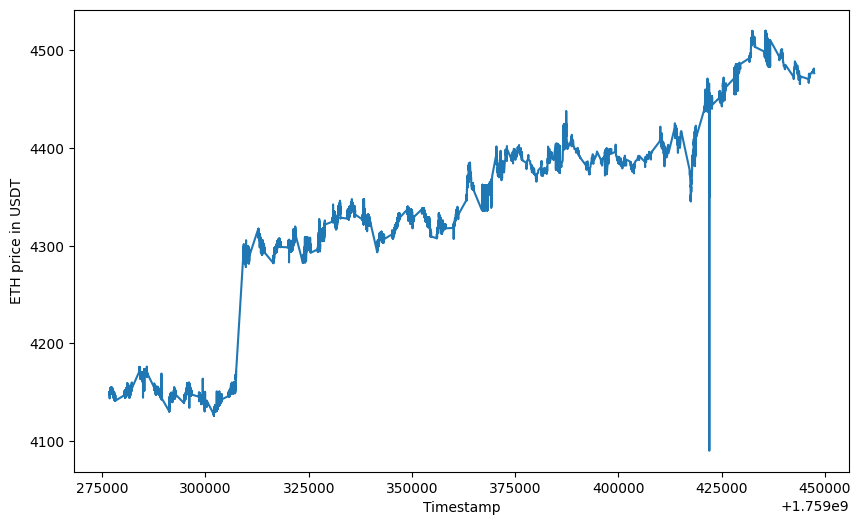

In [26]:
import matplotlib.pyplot as plt
plt.figure(figsize = (10, 6))
plt.plot(df['timestamp'], df['eth_price'])
plt.xlabel('Timestamp')
plt.ylabel('ETH price in USDT')

In [17]:
import asyncio
import aiohttp
import pandas as pd
import time

# -------------------------
# CONFIG
# -------------------------
API_KEY = "YOUR_KEY_HERE"
SUBGRAPH_ID = "HMuAwufqZ1YCRmzL2SfHTVkzZovC9VL2UAKhjvRqKiR1"
URL = f"https://gateway.thegraph.com/api/{API_KEY}/subgraphs/id/{SUBGRAPH_ID}"

START_TS = 1759276800      # Oct 1 2025
END_TS   = 1759449600      # Oct 3 2025

WINDOW_SIZE = 3600         # 1 hour windows
PAGE_SIZE = 1000
MAX_RETRIES = 5
CONCURRENT_REQUESTS = 40

# Canonical token addresses (Arbitrum One)
ETH_ADDRS = {
    "0x82af49447d8a07e3bd95bd0d56f35241523fbab1",  # WETH
    "0x4200000000000000000000000000000000000006",  # Native ETH wrapper (Arbitrum)
}


USDT_ADDRS = {
    "0xfd086bc7cd5c481dcc9c85ebe478a1c0b69fcbb9"
}


# -------------------------
# GRAPHQL QUERY BUILDER
# -------------------------
def build_query(start_ts, end_ts, skip):
    return {
        "query": f"""
        {{
          swaps(
            first: {PAGE_SIZE},
            skip: {skip},
            where: {{
              timestamp_gte: {start_ts},
              timestamp_lt: {end_ts}
            }},
            orderBy: timestamp,
            orderDirection: asc
          ) {{
            id
            timestamp
            amount0
            amount1
            amountUSD
            pool {{
              id
              token0 {{ id symbol }}
              token1 {{ id symbol }}
            }}
          }}
        }}
        """
    }


# -------------------------
# FETCH A SINGLE PAGE
# -------------------------
async def fetch_page(session, start_ts, end_ts, skip, retry=0):
    try:
        async with session.post(URL, json=build_query(start_ts, end_ts, skip), timeout=30) as resp:
            data = await resp.json()

            if "errors" in data:
                if retry < MAX_RETRIES:
                    await asyncio.sleep(0.2)
                    return await fetch_page(session, start_ts, end_ts, skip, retry + 1)
                return []

            return data["data"]["swaps"]

    except Exception:
        if retry < MAX_RETRIES:
            await asyncio.sleep(0.3)
            return await fetch_page(session, start_ts, end_ts, skip, retry + 1)
        return []


# -------------------------
# FETCH ALL PAGES FOR A 1-HOUR WINDOW
# -------------------------
async def fetch_window(session, start_ts, end_ts):
    swaps = []
    skip = 0

    # Fetch first page
    first = await fetch_page(session, start_ts, end_ts, skip)
    if not first:
        return []

    swaps.extend(first)

    # If exactly PAGE_SIZE, paginate
    while len(first) == PAGE_SIZE:
        skip += PAGE_SIZE
        first = await fetch_page(session, start_ts, end_ts, skip)
        if not first:
            break
        swaps.extend(first)

    return swaps


# -------------------------
# FETCH ALL WINDOWS IN PARALLEL
# -------------------------
async def fetch_all_swaps():
    tasks = []
    ts = START_TS

    async with aiohttp.ClientSession() as session:
        while ts < END_TS:
            tasks.append(fetch_window(session, ts, ts + WINDOW_SIZE))
            ts += WINDOW_SIZE

        print(f"Launching {len(tasks)} hourly windows...")

        sem = asyncio.Semaphore(CONCURRENT_REQUESTS)

        async def sem_task(t):
            async with sem:
                return await t

        results = await asyncio.gather(*[sem_task(t) for t in tasks])

    # Flatten
    swaps = [s for window in results for s in window]
    print("Total swaps fetched:", len(swaps))
    return swaps


# -------------------------
# EXTRACT ETH/USDT POOLS (CORRECTED)
# -------------------------
def extract_eth_usdt_pools(swaps):
    pools = set()

    for s in swaps:
        t0 = s["pool"]["token0"]["id"].lower()
        t1 = s["pool"]["token1"]["id"].lower()
        pid = s["pool"]["id"]

        if (t0 in ETH_ADDRS and t1 in USDT_ADDRS) or \
           (t1 in ETH_ADDRS and t0 in USDT_ADDRS):
            pools.add(pid)

    print("ETH/USDT pools identified:", pools)
    return pools


# -------------------------
# NORMALIZE SWAP DATA
# -------------------------
def normalize_swap(s):
    t0 = s["pool"]["token0"]["id"].lower()
    t1 = s["pool"]["token1"]["id"].lower()

    a0 = float(s["amount0"])
    a1 = float(s["amount1"])

    # Determine which amount belongs to ETH vs USDT
    if t0 in ETH_ADDRS:
        eth = a0
        usdt = a1
    elif t1 in ETH_ADDRS:
        eth = a1
        usdt = a0
    else:
        return None

    direction = "ETH→USDT" if eth < 0 else "USDT→ETH"

    return {
        "id": s["id"],
        "timestamp": int(s["timestamp"]),
        "eth_amount": eth,
        "usdt_amount": usdt,
        "direction": direction,
        "pool": s["pool"]["id"]
    }


# -------------------------
# MAIN
# -------------------------
async def main():
    all_swaps = await fetch_all_swaps()

    pools = extract_eth_usdt_pools(all_swaps)
    if not pools:
        print("No ETH/USDT pools found.")
        return

    # Filter by pools
    eth_usdt_swaps = [s for s in all_swaps if s["pool"]["id"] in pools]

    # Normalize
    normalized = [normalize_swap(s) for s in eth_usdt_swaps]
    normalized = [n for n in normalized if n is not None]

    df = pd.DataFrame(normalized).sort_values("timestamp")

    print(df.head())
    print("Total ETH/USDT swaps:", len(df))

    df.to_csv("eth_usdt_swaps_clean.csv", index=False)
    print("Saved → eth_usdt_swaps_clean.csv")


# -------------------------
# NOTEBOOK SAFE RUN
# -------------------------
import nest_asyncio
nest_asyncio.apply()

await main()


Launching 48 hourly windows...
Total swaps fetched: 0
ETH/USDT pools identified: set()
No ETH/USDT pools found.
